# Calculating Total Number of USDC Transfered Per Block
Token transfers are at the core of many pieces of analysis. To understand how assets move to and from users and protocols. Used in calculating metrics such as TVL, asset flows and other key metrics 

# Ethereum

In [1]:
import requests
import json
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

In [32]:
ETHEREUM_RPC_URL = "YOUR_ETHEREUM_RPC_URL"
EVENT_SIGNATURE = "0xddf252ad1be2c89b69c2b068fc378daa952ba7f163c4a11628f55a4df523b3ef" # keccak-256 hash of Transfer(address,address,uint256)

contract_address = "0xA0b86991c6218b36c1d19D4a2e9Eb0cE3606eB48"  # USDC Contract Address
start_block = 20871154  # Replace with your start block of interest
end_block = 20871164    # Replace with your end block of interest

In [2]:
def get_token_transfers(contract_address, start_block, end_block, endpoint_url):
    headers = {
        "Content-Type": "application/json"
    }

    transfer_event_signature = EVENT_SIGNATURE 

    # The payload for the eth_getLogs method
    payload = {
        "jsonrpc": "2.0",
        "method": "eth_getLogs",
        "params": [{
            "fromBlock": hex(start_block),  # Starting block
            "toBlock": hex(end_block),      # Ending block
            "address": contract_address,    # Contract address for the token
            "topics": [transfer_event_signature]  # Filter only Transfer events
        }],
        "id": 1
    }

    response = requests.post(endpoint_url, json=payload, headers=headers)

    if response.status_code == 200:
        logs = response.json().get("result", [])
        return logs
    else:
        raise Exception(f"Error fetching logs: {response.status_code} - {response.text}")

In [3]:
def parse_transfer_event(log):
    # Each log contains 'topics' and 'data'
    # Topics[1] is the `from` address, Topics[2] is the `to` address
    from_address = '0x' + log['topics'][1][26:]  # Remove the prefix (first 26 characters)
    to_address = '0x' + log['topics'][2][26:]

    # The amount transferred is stored in the 'data' field. 
    amount = int(log['data'], 16)

    return {
        "from": from_address,
        "to": to_address,
        "amount": amount / 10**6,
        "blockNumber": int(log['blockNumber'], 16),
        "transactionHash": log['transactionHash']
    }

In [4]:
def aggregate_transfers_by_block(transfers):
    # Aggregate token transfers by block number
    block_aggregates = {}

    for transfer in transfers:
        block_number = transfer['blockNumber']
        amount = transfer['amount']

        if block_number in block_aggregates:
            block_aggregates[block_number] += amount
        else:
            block_aggregates[block_number] = amount

    return block_aggregates

In [5]:
def plot_token_transfers_by_block(block_aggregates):
    # Convert the block data into a Pandas DataFrame
    df = pd.DataFrame(list(block_aggregates.items()), columns=['Block Number', 'Total Transfer Amount'])

    # Plot the total token transfers per block using Pandas
    ax = df.plot(x='Block Number', y='Total Transfer Amount', kind='line', marker='o', figsize=(10, 6))

    # Set x-ticks for all block numbers
    ax.set_xticks(df['Block Number'])
    ax.set_xticklabels(df['Block Number'], rotation=45, ha='right')  # Rotate for readability

    # Disable scientific notation on y-axis
    ax.get_yaxis().set_major_formatter(ScalarFormatter(useOffset=False))
    ax.ticklabel_format(useOffset=False, style='plain', axis='y')

    plt.title("Total USDC Tokens Transfered by Block")
    plt.xlabel("Block Number")
    plt.ylabel("Total Token Transfer Amount")
    plt.grid(True)
    plt.tight_layout()  # Adjust layout to ensure labels fit well
    plt.show()

Block 20871154: 34901444.132003 tokens transferred
Block 20871155: 987829.9371789999 tokens transferred
Block 20871156: 666491.6423719998 tokens transferred
Block 20871157: 110478.25946100001 tokens transferred
Block 20871158: 172216.766312 tokens transferred
Block 20871159: 291543.36799400003 tokens transferred
Block 20871160: 32100835.219303995 tokens transferred
Block 20871161: 1094121.561677 tokens transferred
Block 20871162: 3117506.363184 tokens transferred
Block 20871163: 224669.155119 tokens transferred
Block 20871164: 155713.475687 tokens transferred


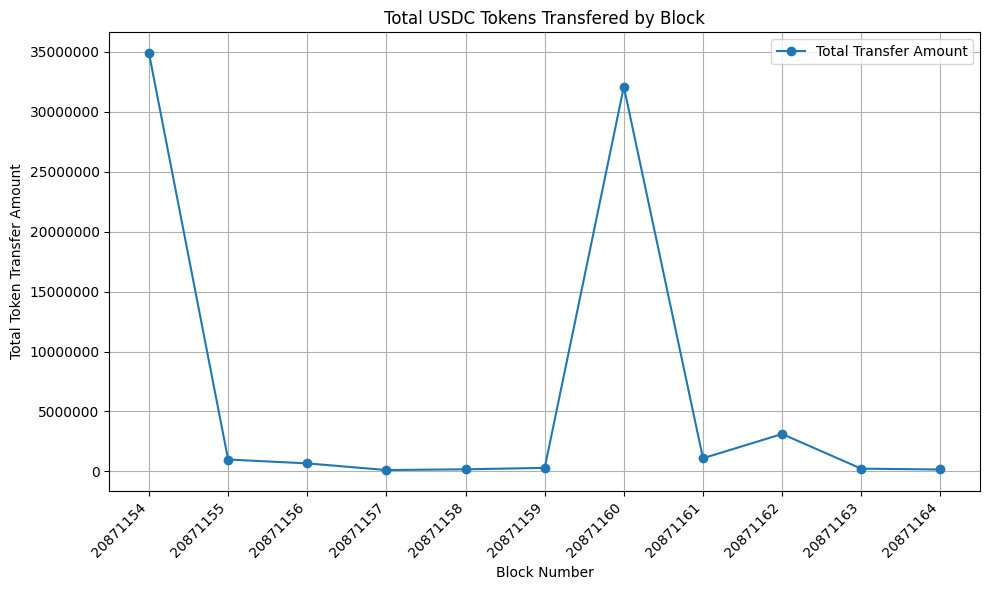

In [6]:
try:
    # Fetch logs and parse the transfers
    logs = get_token_transfers(contract_address, start_block, end_block, ETHEREUM_RPC_URL)
    transfers = [parse_transfer_event(log) for log in logs]

    # Aggregate the transfers by block number
    block_aggregates = aggregate_transfers_by_block(transfers)

    # Display the total token transfers by block
    for block_number, total_amount in block_aggregates.items():
        print(f"Block {block_number}: {total_amount} tokens transferred")

    # Plot the token transfers by block
    plot_token_transfers_by_block(block_aggregates)

except Exception as e:
    print(e)

# Solana

In [33]:
SOLANA_RPC_URL = "YOUR_SOLANA_RPC_URL"
# Headers for the request
HEADERS = {
    "Content-Type": "application/json"
}

# USDC Token Mint Address on Solana
USDC_MINT = "EPjFWdd5AufqSSqeM2qN1xzybapC8G4wEGGkZwyTDt1v"

# Define the block range
start_block = 294291896
end_block = 294291905 

### Approach #1: Fetch Transfers

In [ ]:
def fetch_block_transactions(block: int):
    payload = {
        "jsonrpc": "2.0",
        "id": 1,
        "method": "getBlock",
        "params": [
            block,  # The block number to query
            {       # Configuring the max supported transaction version
                "encoding": "jsonParsed",
                "maxSupportedTransactionVersion": 0
            }
        ]
    }

    response = requests.post(SOLANA_RPC_URL, headers=HEADERS, json=payload)
    print(response.json())
    # Check if the response was successful
    if response.status_code != 200:
        print(f"Error: Failed to fetch block {block}, HTTP status code: {response.status_code}")
        print(f"Response text: {response.text}")
        return {}

    # Check for JSON parsing errors
    try:
        result = response.json().get('result', {})
    except json.JSONDecodeError:
        print(f"Error: Failed to decode JSON response for block {block}")
        print(f"Response text: {response.text}")
        return {}

    # Check if the result contains transactions
    if not result:
        print(f"Warning: No data returned for block {block}")
    else:
        print(f"Success: Data found for block {block}")
    
    return result

In [ ]:
def get_token_account_details(token_account_address):
    """
    Retrieves the mint address and owner of a token account.

    Args:
        token_account_address (str): The token account's public key.

    Returns:
        dict or None: A dictionary containing 'mint', 'owner', 'decimals', and 'amount' keys, or None if not found.
    """
    payload = {
        "jsonrpc": "2.0",
        "id": 1,
        "method": "getAccountInfo",
        "params": [
            token_account_address,
            {
                "encoding": "jsonParsed",
                "commitment": "finalized"
            }
        ]
    }
    response = requests.post(SOLANA_RPC_URL, headers=HEADERS, json=payload)
    response.raise_for_status()
    result = response.json()
    print(json.dumps(result, indent=4))
    value = result.get('result', {}).get('value', None)
    if value is None:
        print(f"No account data found for {token_account_address}")
        return None
    data = value.get('data', {})
    parsed = data.get('parsed', {})
    info = parsed.get('info', {})
    mint_address = info.get('mint', None)
    owner_address = info.get('owner', None)
    token_amount = info.get('tokenAmount', {})
    decimals = token_amount.get('decimals', None)
    amount = token_amount.get('amount', None)
    return {
        'mint': mint_address,
        'owner': owner_address,
        'decimals': decimals,
        'amount': amount
    }

In [ ]:
def parse_token_transfers(transactions, block_number):
    transfers = []
    token_account_cache = {}  # Cache to store token account details

    # Loop through each transaction
    for txn in transactions:
        # Check if the transaction failed
        if txn.get('meta', {}).get('err') is not None:
            continue  # Skip failed transactions

        txn_hash = txn.get('transaction', {}).get('signatures', [None])[0]  # Get the transaction hash

        # Helper function to get token account details with caching
        def get_token_account_details_cached(account_address):
            if account_address in token_account_cache:
                return token_account_cache[account_address]
            details = get_token_account_details(account_address)
            token_account_cache[account_address] = details
            return details

        # Process outer instructions
        if "meta" in txn and "preTokenBalances" in txn["meta"] and "postTokenBalances" in txn["meta"]:
            for outer_index, instruction in enumerate(txn.get("transaction", {}).get("message", {}).get("instructions", [])):
                program_id = instruction.get("programId")
                if program_id in ["TokenkegQfeZyiNwAJbNbGKPFXCWuBvf9Ss623VQ5DA", "TokenzQdBNbLqP5VEhdkAS6EPFLC1PHnBqCXEpPxuEb"]:
                    parsed = instruction.get("parsed", {})
                    if parsed and parsed.get("type") in ["transfer", "transferChecked", "mintTo", "burn"]:
                        info = parsed.get("info", {})
                        amount = info.get("tokenAmount", {}).get("amount") or info.get("amount")
                        source = info.get("source")
                        destination = info.get("destination")

                        # Get source and destination token account details
                        source_details = get_token_account_details_cached(source) if source else None
                        destination_details = get_token_account_details_cached(destination) if destination else None

                        # Obtain the mint address and decimals from the first non-null source or destination account details
                        mint = None
                        decimals = None
                        if source_details:
                            if source_details.get('mint'):
                                mint = source_details['mint']
                            if source_details.get('decimals') is not None:
                                decimals = source_details['decimals']
                        if mint is None and destination_details and destination_details.get('mint'):
                            mint = destination_details['mint']
                        if decimals is None and destination_details and destination_details.get('decimals') is not None:
                            decimals = destination_details['decimals']

                        # Set the program_token_type based on the programId
                        program_token_type = "spl_token" if program_id == "TokenkegQfeZyiNwAJbNbGKPFXCWuBvf9Ss623VQ5DA" else "spl_token_2022"

                        transfers.append({
                            "block_number": block_number,  # Include block number
                            "type": parsed["type"],
                            "amount": amount,
                            "decimals": decimals,  # Decimals from token account details
                            "source": source,
                            "source_owner": source_details['owner'] if source_details else None,
                            "source_mint": source_details['mint'] if source_details else None,
                            "destination": destination,
                            "destination_owner": destination_details['owner'] if destination_details else None,
                            "destination_mint": destination_details['mint'] if destination_details else None,
                            "token_contract": mint,  # Mint address from source or destination account details
                            "transaction_hash": txn_hash,
                            "programId": program_id,
                            "program_token_type": program_token_type,  # spl_token or spl_token_2022
                            "is_outer": True,
                            "outer_index": outer_index,
                            "inner_index": None  # No inner index for outer instructions
                        })

        # Process inner instructions
        if "innerInstructions" in txn["meta"]:
            for inner_instruction in txn["meta"]["innerInstructions"]:
                outer_index = inner_instruction.get("index")  # Get the outer index related to this inner instruction
                for inner_instruction_index, instruction in enumerate(inner_instruction.get("instructions", [])):
                    program_id = instruction.get("programId")
                    if program_id in ["TokenkegQfeZyiNwAJbNbGKPFXCWuBvf9Ss623VQ5DA", "TokenzQdBNbLqP5VEhdkAS6EPFLC1PHnBqCXEpPxuEb"]:
                        parsed = instruction.get("parsed", {})
                        if parsed and parsed.get("type") in ["transfer", "transferChecked", "mintTo", "burn"]:
                            info = parsed.get("info", {})
                            amount = info.get("tokenAmount", {}).get("amount") or info.get("amount")
                            source = info.get("source")
                            destination = info.get("destination")

                            # Get source and destination token account details
                            source_details = get_token_account_details_cached(source) if source else None
                            destination_details = get_token_account_details_cached(destination) if destination else None

                            # Obtain the mint address and decimals from the first non-null source or destination account details
                            mint = None
                            decimals = None
                            if source_details:
                                if source_details.get('mint'):
                                    mint = source_details['mint']
                                if source_details.get('decimals') is not None:
                                    decimals = source_details['decimals']
                            if mint is None and destination_details and destination_details.get('mint'):
                                mint = destination_details['mint']
                            if decimals is None and destination_details and destination_details.get('decimals') is not None:
                                decimals = destination_details['decimals']

                            # Set the program_token_type based on the programId
                            program_token_type = "spl_token" if program_id == "TokenkegQfeZyiNwAJbNbGKPFXCWuBvf9Ss623VQ5DA" else "spl_token_2022"

                            transfers.append({
                                "block_number": block_number,  # Include block number
                                "type": parsed["type"],
                                "amount": amount,
                                "decimals": decimals,  # Decimals from token account details
                                "source": source,
                                "source_owner": source_details['owner'] if source_details else None,
                                "source_mint": source_details['mint'] if source_details else None,
                                "destination": destination,
                                "destination_owner": destination_details['owner'] if destination_details else None,
                                "destination_mint": destination_details['mint'] if destination_details else None,
                                "token_contract": mint,  # Mint address from source or destination account details
                                "transaction_hash": txn_hash,
                                "programId": program_id,
                                "program_token_type": program_token_type,  # spl_token or spl_token_2022
                                "is_outer": False,
                                "outer_index": outer_index,  # Outer index associated with this inner instruction
                                "inner_index": inner_instruction_index  # Inner instruction index
                            })

    return transfers

In [ ]:
# Initialize an empty list to collect all transfers
all_transfers = []

In [ ]:
# Loop over the block range
for block_number in range(start_block, end_block + 1):
    print(f"Processing block {block_number}...")
    block_data = fetch_block_transactions(block_number)
    transactions = block_data.get('transactions', [])

    if not transactions:
        print(f"No transactions found in block {block_number}.")
        continue

    # Parse token transfers from the transactions, passing the block_number
    transfers = parse_token_transfers(transactions, block_number)

    if transfers:
        print(f"Transfers found in block {block_number}: {len(transfers)} transfers")
        # Append transfers to the all_transfers list
        all_transfers.extend(transfers)
    else:
        print(f"No token transfers found in block {block_number}.")

    # Optional: Sleep to respect rate limits
    time.sleep(0.1)  # Adjust the sleep time as neede

print("Finished processing the block range.")

In [ ]:
# Create a DataFrame from all_transfers
df_transfers = pd.DataFrame(all_transfers)

In [ ]:
#Filter our Transfers for Just USDC. 
usdc_transfers = df_transfers[
    (df_transfers['source_mint'] == USDC_MINT) | (df_transfers['destination_mint'] == USDC_MINT)
]

In [ ]:
# Ensure 'amount' and 'decimals' are numeric
usdc_transfers['amount'] = pd.to_numeric(usdc_transfers['amount'], errors='coerce')
usdc_transfers['decimals'] = pd.to_numeric(usdc_transfers['decimals'], errors='coerce')

# Calculate 'amount_clean' as 'amount' divided by 10 raised to the power of 'decimals'
usdc_transfers['amount_clean'] = usdc_transfers['amount'] / (10 ** usdc_transfers['decimals'])

In [ ]:
# Ensure 'amount_clean' and 'block_number' are numeric
usdc_transfers['amount_clean'] = pd.to_numeric(usdc_transfers['amount_clean'], errors='coerce')
usdc_transfers['block_number'] = pd.to_numeric(usdc_transfers['block_number'], errors='coerce')

# Group by 'block_number' and sum 'amount_clean'
amount_by_block = usdc_transfers.groupby('block_number')['amount_clean'].sum().reset_index()

# Sort by 'block_number'
amount_by_block = amount_by_block.sort_values('block_number')
amount_by_block['block_number'] = amount_by_block['block_number'].astype(int)

In [ ]:
amount_by_block['block_number_normalized'] = amount_by_block['block_number'] - amount_by_block['block_number'].min()

plt.figure(figsize=(12, 6))
plt.plot(amount_by_block['block_number_normalized'], amount_by_block['amount_clean'], marker='o', linestyle='-', color='blue')

plt.xlabel('Block Number')
plt.ylabel('Total USDC Transferred')
plt.title('Total USDC Transferred by Block Number')

plt.xticks(amount_by_block['block_number_normalized'], amount_by_block['block_number'], rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

### Approach #2: Pre & Post Token Balance Changes

In [27]:
# Function to process token balances for a single transaction
def get_token_balance_df(response, transaction_id, block_number):
    pre_balances = response['meta']['preTokenBalances']
    post_balances = response['meta']['postTokenBalances']
    account_keys = response['transaction']['message']['accountKeys']  # Extract accountKeys from the transaction message
    
    # Create a dictionary to hold the token balances mapped by (accountIndex, mint, owner, programId)
    balance_map = {}

    # Populate the pre-token balances into the map
    for pre_balance in pre_balances:
        account_index = pre_balance['accountIndex']
        key = (
            account_index,
            pre_balance['mint'],
            pre_balance['owner'],
            pre_balance['programId']
        )
        balance_map[key] = {
            'PreAmount': float(pre_balance['uiTokenAmount']['uiAmountString']) if pre_balance['uiTokenAmount']['uiAmount'] is not None else 0,
            'PostAmount': 0,  # Set post amount to 0 initially
            'Pubkey': account_keys[account_index]['pubkey']  # Map the pubkey using accountIndex
        }

    # Populate the post-token balances, update the map with the post values
    for post_balance in post_balances:
        account_index = post_balance['accountIndex']
        key = (
            account_index,
            post_balance['mint'],
            post_balance['owner'],
            post_balance['programId']
        )
        if key in balance_map:
            balance_map[key]['PostAmount'] = float(post_balance['uiTokenAmount']['uiAmountString']) if post_balance['uiTokenAmount']['uiAmount'] is not None else 0
        else:
            # If the post balance has no matching pre balance, add it with preAmount = 0
            balance_map[key] = {
                'PreAmount': 0,
                'PostAmount': float(post_balance['uiTokenAmount']['uiAmountString']) if post_balance['uiTokenAmount']['uiAmount'] is not None else 0,
                'Pubkey': account_keys[account_index]['pubkey']  # Map the pubkey using accountIndex
            }

    # Convert the map into a list of dictionaries for DataFrame creation
    balance_data = [
        {
            'Pubkey': value['Pubkey'],
            'Owner': key[2],
            'PreAmount': value['PreAmount'],
            'PostAmount': value['PostAmount'],
            'Change': value['PostAmount'] - value['PreAmount'],
            'AccountIndex': key[0],
            'Mint': key[1],
            'TransactionId': transaction_id, 
            'BlockNumber': block_number       
        }
        for key, value in balance_map.items()
    ]

    # Convert the list of dictionaries into a pandas DataFrame
    df = pd.DataFrame(balance_data)
    return df

In [28]:
# Function to process all transactions across a range of blocks
def process_token_balances_for_block_range(start_block, end_block):
    all_balances = []  # List to hold all DataFrames

    for block_number in range(start_block, end_block + 1):
        print(f"Processing block {block_number}")
        block_data = fetch_block_transactions(block_number)

        if block_data is None or 'transactions' not in block_data:
            continue  # Skip if there's no transaction data for this block

        # Process each transaction in the block
        for tx in block_data['transactions']:
            transaction_id = tx['transaction']['signatures'][0]  # Transaction ID (first signature)
            df = get_token_balance_df(tx, transaction_id, block_number)  # Process the transaction
            all_balances.append(df)  # Add the resulting DataFrame to the list

    # Concatenate all DataFrames into one
    final_df = pd.concat(all_balances, ignore_index=True)
    return final_df

In [19]:
# Process token balances for the block range
final_df = process_token_balances_for_block_range(start_block, end_block)

Processing block 294291896
Processing block 294291897
Processing block 294291898
Processing block 294291899
Processing block 294291900
Processing block 294291901
Processing block 294291902
Processing block 294291903
Processing block 294291904
Processing block 294291905


In [29]:
# Filter Just USDC Address Balance changes. 
usdc_balance_changes = final_df[(final_df['Mint'] == USDC_MINT) & (final_df['Change'] >= 0)]

In [30]:
usdc_changes_by_block = usdc_balance_changes.groupby('BlockNumber')['Change'].sum()

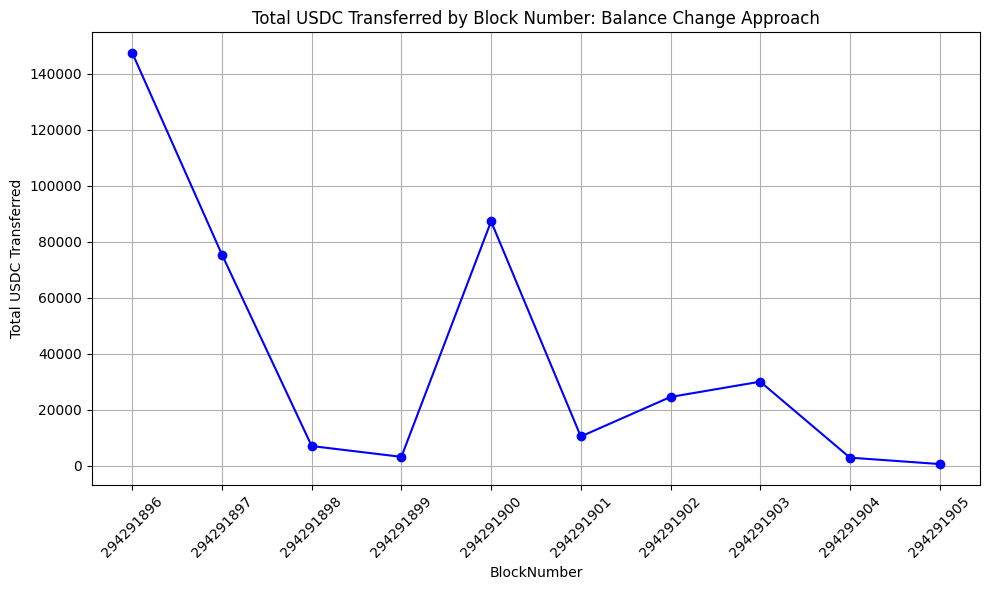

In [31]:
# Plotting the results as a line chart with the x-axis showing block numbers
plt.figure(figsize=(10, 6))
plt.plot(usdc_changes_by_block.index, usdc_changes_by_block.values, marker='o', linestyle='-', color='blue')

# Setting block numbers as x-axis labels
plt.title('Total USDC Transferred by Block Number: Balance Change Approach')
plt.xlabel('BlockNumber')
plt.ylabel('Total USDC Transferred')
plt.xticks(ticks=usdc_changes_by_block.index, labels=usdc_changes_by_block.index, rotation=45)
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()